# Preprocessing

### Examine the Dataset

In [29]:
import librosa.display
import libroas.util
import matplotlib.pyplot as plt
from IPython.display import Audio
import os
import scipy
import numpy as np

In [19]:
clean_audio_dir = "../data/raw/clean_trainset_28spk_wav/"
audio_file = "p236_002.wav"
clean_audio_f = clean_audio_dir + audio_file
Audio(clean_audio_f)

In [20]:
noisy_audio_dir = "../data/raw/noisy_trainset_28spk_wav/"
noisy_audio_f = noisy_audio_dir + audio_file

Audio(noisy_audio_f)

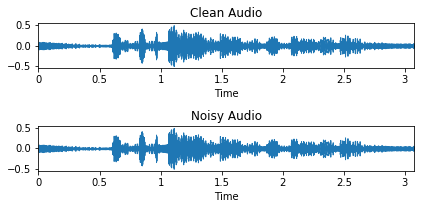

In [21]:
# Plot the waveforms, sr = 22050
y, sr = librosa.load(clean_audio_f)
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Clean Audio')

y_noise, sr = librosa.load(clean_audio_f)
plt.subplot(3, 1, 2)
librosa.display.waveplot(y, sr=sr)
plt.title('Noisy Audio')

plt.tight_layout()

### Short-Time Fourier Transform

First, convert samples into STFT

In [68]:
window_length = 256;
win = scipy.signal.hamming(window_length,"periodic");
overlap = round(0.75 * window_length);
fft_length = window_length;

# for later use in downsampling to 8k
input_fs = sr;
fs = 8e3;

n = len(y)

In [70]:
y_pad = librosa.util.fix_length(y, n + fft_length // 2)
D = librosa.stft(y_pad.astype(np.float32),
    n_fft = fft_length,
    win_length = window_length,
    window = win,
    hop_length = overlap)
magnitude, phase = librosa.magphase(D)

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x7f2cc8d416a0>>
Traceback (most recent call last):
  File "/home/colm/anaconda3/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/home/colm/anaconda3/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/home/colm/anaconda3/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


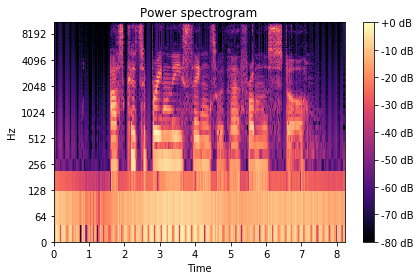

In [80]:
librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

At this point, we will use the generate new magnitudes using our NN

Then, invert STFT back to audio format

In [72]:
D_rec = magnitude * phase 

In [73]:
audio_rec = librosa.istft(D_rec,
    length=n,
    win_length = window_length,
    window = win,
    hop_length = overlap)

In [79]:
Audio(audio_rec, rate = sr)

### Full Script

TODO: Full Script which will take process all the audio files in raw format and store them in processed format, using the above constraints

Script should store data in a format that can be easily saved are retrieved for later use